<a href="https://colab.research.google.com/github/keran-w/Projects-in-ML-and-AI/blob/main/ProjML%26AI_hw5_task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 5 -- CNNs, AEs, GANs
https://submitty.cs.rpi.edu/courses/f22/csci4962/course_material/Homeworks/Homework%205.pdf

https://github.com/keran-w/Projects-in-ML-and-AI/blob/main/ProjML%26AI_hw5.ipynb

In [ ]:
# connect to google drive
from google.colab import drive
from IPython.display import clear_output
drive.mount('/content/drive', force_remount=True)
clear_output()

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set a fixed randomness
import os
import torch
import random   
import numpy as np
def seed_everything(seed=20):
    """set seed for all"""
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [ ]:
# import dataset from kaggle
if not os.path.isfile('~/.kaggle/kaggle.json'):
    os.system('mkdir ~/.kaggle')
    os.system('cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json')

!kaggle datasets download -d misrakahmed/vegetable-image-dataset
!unzip vegetable-image-dataset.zip -d .
clear_output()

In [ ]:
import torchvision
transform = {
    'train': torchvision.transforms.Compose([
        torchvision.transforms.Resize([224,224]),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
    ]),
    'test': torchvision.transforms.Compose([
        torchvision.transforms.Resize([224,224]),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
    ])
}

img_path = 'Vegetable Images'
train_set = torchvision.datasets.ImageFolder(f'{img_path}/train', transform=transform['train'])
valid_set = torchvision.datasets.ImageFolder(f'{img_path}/validation', transform=transform['test'])
test_set = torchvision.datasets.ImageFolder(f'{img_path}/test', transform=transform['test'])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

In [ ]:
sample_batch = next(iter(train_loader))
print('Batch image shape:', sample_batch[0].shape)
print('Batch label shape:', sample_batch[1].shape)
print('Label to id:\n\t', '\n\t'.join([f'{k}({v})' for k,v in train_set.class_to_idx.items()]), sep='')
label_map = {v:k for k,v in train_set.class_to_idx.items()}
num_classes = len(label_map)

Batch image shape: torch.Size([32, 3, 224, 224])
Batch label shape: torch.Size([32])
Label to id:
	Bean(0)
	Bitter_Gourd(1)
	Bottle_Gourd(2)
	Brinjal(3)
	Broccoli(4)
	Cabbage(5)
	Capsicum(6)
	Carrot(7)
	Cauliflower(8)
	Cucumber(9)
	Papaya(10)
	Potato(11)
	Pumpkin(12)
	Radish(13)
	Tomato(14)


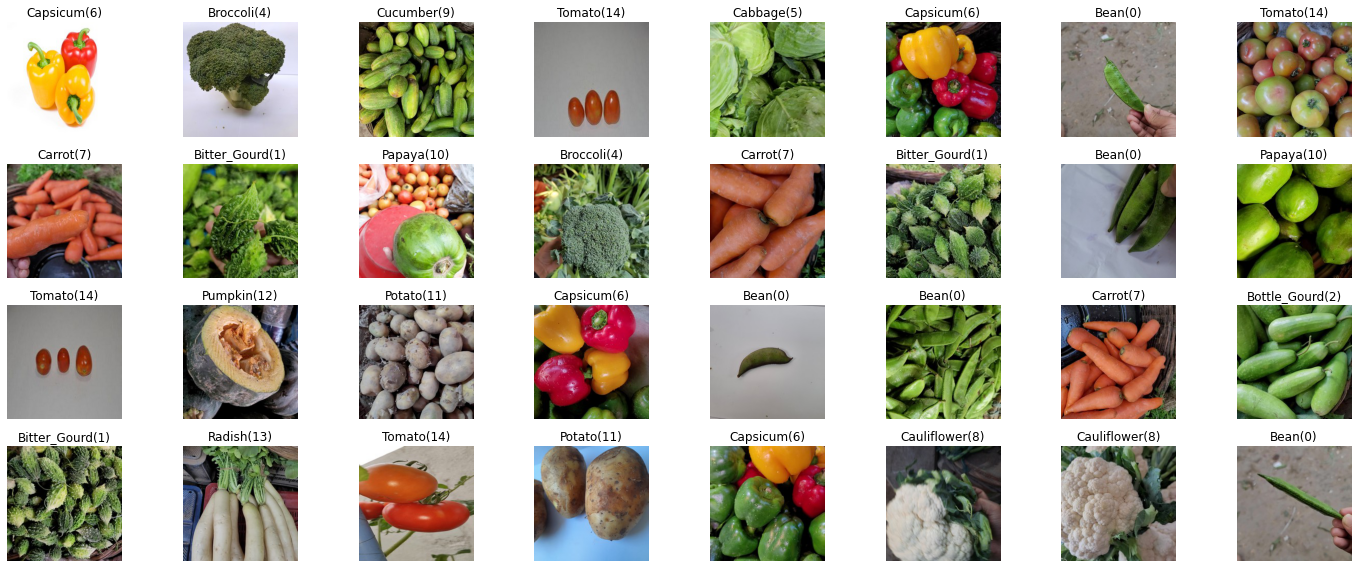

In [ ]:
# Random batch visualization
import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

# create a sample batch
sample_batch = next(iter(train_loader))
sample_images, sample_labels = sample_batch

sample_count = 32
rows = sample_count // 8
figure, ax = plt.subplots(nrows=rows, ncols=8, figsize=(20, sample_count // rows))

for i, idx in enumerate(range(32)):
    image, label = sample_images[idx], sample_labels[idx]
    image = image / 2 + 0.5
    ax.ravel()[i].imshow(np.transpose(image, (1, 2, 0)))
    title = f'{label_map[sample_labels[idx].item()]}({sample_labels[idx]})'
    ax.ravel()[i].set_title(title)
    ax.ravel()[i].set_axis_off()
    
plt.tight_layout()
plt.show()

In [ ]:
from torch import nn
class CNNClassifier(nn.Module):
    def __init__(self, num_classes, device):
        super().__init__()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), 
            nn.GELU(),
            nn.MaxPool2d(kernel_size=3, stride=3),
            nn.LazyConv2d(16, kernel_size=5), 
            nn.GELU(),
            nn.MaxPool2d(kernel_size=3, stride=3),
            nn.Flatten(1),
            nn.LazyLinear(128), 
            nn.GELU(),
            nn.LazyLinear(num_classes)
        )
        self.device = device
        self.to(device)

    def forward(self, image):
        image = torch.tensor(image).to(self.device)
        return self.net(image)

# Define hyperparameters
n_epoch = 20
learning_rate = 1e-4
weight_decay = 1e-3

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNNClassifier(num_classes, device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# test a sample batch
logits = model(sample_batch[0])
true_labels = sample_batch[1].long().to(device)
print('Model output shape:', logits.shape)
loss = criterion(logits, true_labels)
print('Make sure loss is scalar:', loss.item())

Model output shape: torch.Size([32, 15])
Make sure loss is scalar: 2.7070772647857666


In [ ]:
from tqdm.autonotebook import tqdm

# Define train step
def train_step(batch, model, criterion, optimizer, device):
    optimizer.zero_grad()
    logits = model(batch[0])
    true_labels = batch[1].long().to(device)
    loss = criterion(logits, true_labels)
    loss.backward()
    optimizer.step()
    return loss.item()

# Define valid step
def valid_step(batch, model, device):
    logits = model(batch[0]).detach()
    true_labels = batch[1].long().to(device)
    acc = (logits.argmax(1) == true_labels).float().mean().item()
    return acc

# Define runner
def runner(train_loader, valid_loader, n_epoch, model, criterion, optimizer, device):
    avg_train_loss_list, avg_valid_acc_list = [], []
    for epoch in range(n_epoch):
        # Initialize epoch metrics
        train_loss_list, valid_acc_list = [], []

        # Training process
        model.train()
        for train_batch in tqdm(train_loader):
            train_loss = train_step(train_batch, model, criterion, optimizer, device)
            train_loss_list.append(train_loss)
        avg_train_loss = np.mean(train_loss_list)
        avg_train_loss_list.append(avg_train_loss)

        # Validating process
        model.eval()
        with torch.no_grad():
            for valid_batch in tqdm(valid_loader):
                valid_acc = valid_step(valid_batch, model, device)
                valid_acc_list.append(valid_acc)
        avg_valid_acc = np.mean(valid_acc_list)
        avg_valid_acc_list.append(avg_valid_acc)
        print('Epoch metrics:', f'avg_train_loss={avg_train_loss}, avg_valid_acc={avg_valid_acc}, ')
    return avg_train_loss_list, avg_valid_acc_list

avg_train_loss_list, avg_valid_acc_list = runner(train_loader, valid_loader, n_epoch, model, criterion, optimizer, device)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=1.7876072937745784, avg_valid_acc=0.5988475179418604, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=1.0991100274931902, avg_valid_acc=0.716866134963137, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.733554898675825, avg_valid_acc=0.810616134963137, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.5248720657342533, avg_valid_acc=0.840979610351806, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.40586158493434443, avg_valid_acc=0.8686835106382979, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.3228457090871802, avg_valid_acc=0.8828679082241464, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.26489571385037924, avg_valid_acc=0.8951684401390401, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.22748439477832078, avg_valid_acc=0.8848625890752102, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.185318884334521, avg_valid_acc=0.9207668443943592, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.15880567204755253, avg_valid_acc=0.9089095744680851, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.14063340068054098, avg_valid_acc=0.9244237592879762, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.1150668204140498, avg_valid_acc=0.9277482273730826, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.09823190659554655, avg_valid_acc=0.9330673763092528, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.08499381815327574, avg_valid_acc=0.9298537234042553, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.07364301563802558, avg_valid_acc=0.9391622340425532, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.06764528010862628, avg_valid_acc=0.9351728723404256, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.05630496780036577, avg_valid_acc=0.9280806741815932, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.057188666009628124, avg_valid_acc=0.9278590425531915, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.045790299100042786, avg_valid_acc=0.941156914893617, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.04503565102315216, avg_valid_acc=0.9305186170212766, 


In [ ]:
test_acc_list = []
model.eval()
with torch.no_grad():
    for test_batch in tqdm(test_loader):
        test_acc = valid_step(test_batch, model, device)
        test_acc_list.append(test_acc)
print(np.mean(test_acc_list))

  0%|          | 0/94 [00:00<?, ?it/s]

0.9314051422666996


In [ ]:
from torchvision import models as M
mobilenet = M.mobilenet_v2(pretrained=True)
mobilenet.out = nn.LazyLinear(num_classes)
mobilenet = mobilenet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobilenet.parameters(), lr=learning_rate, weight_decay=weight_decay)

# test a sample batch
logits = mobilenet.out(mobilenet(sample_batch[0].to(device)))
true_labels = sample_batch[1].long().to(device)
print('Model output shape:', logits.shape)
loss = criterion(logits, true_labels)
print('Make sure loss is scalar:', loss.item())

Model output shape: torch.Size([32, 15])
Make sure loss is scalar: 3.662205457687378


In [ ]:
# Define train step
def train_step(batch, model, criterion, optimizer, device):
    optimizer.zero_grad()
    logits = model.out(model(batch[0].to(device)))
    true_labels = batch[1].long().to(device)
    loss = criterion(logits, true_labels)
    loss.backward()
    optimizer.step()
    return loss.item()

# Define valid step
def valid_step(batch, model, device):
    logits = model.out(model(batch[0].to(device))).detach()
    true_labels = batch[1].long().to(device)
    acc = (logits.argmax(1) == true_labels).float().mean().item()
    return acc

# Define runner
def runner(train_loader, valid_loader, n_epoch, model, criterion, optimizer, device):
    avg_train_loss_list, avg_valid_acc_list = [], []
    for epoch in range(n_epoch):
        # Initialize epoch metrics
        train_loss_list, valid_acc_list = [], []

        # Training process
        model.train()
        for train_batch in tqdm(train_loader):
            train_loss = train_step(train_batch, model, criterion, optimizer, device)
            train_loss_list.append(train_loss)
        avg_train_loss = np.mean(train_loss_list)
        avg_train_loss_list.append(avg_train_loss)

        # Validating process
        model.eval()
        with torch.no_grad():
            for valid_batch in tqdm(valid_loader):
                valid_acc = valid_step(valid_batch, model, device)
                valid_acc_list.append(valid_acc)
        avg_valid_acc = np.mean(valid_acc_list)
        avg_valid_acc_list.append(avg_valid_acc)
        print('Epoch metrics:', f'avg_train_loss={avg_train_loss}, avg_valid_acc={avg_valid_acc}, ')
    return avg_train_loss_list, avg_valid_acc_list

mn_avg_train_loss_list, mn_avg_valid_acc_list = runner(train_loader, valid_loader, n_epoch, mobilenet, criterion, optimizer, device)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.0928507243667338, avg_valid_acc=0.9986702127659575, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.011457561564512365, avg_valid_acc=0.9983377659574468, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.011778977141919871, avg_valid_acc=0.9983377659574468, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.00737509093133514, avg_valid_acc=0.9990026595744681, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.013587598444093197, avg_valid_acc=0.9956781914893617, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.013795105780019109, avg_valid_acc=0.9956781914893617, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.007124165574969627, avg_valid_acc=0.9983377659574468, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.007326519520396539, avg_valid_acc=0.9996675531914894, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.009434429704874276, avg_valid_acc=0.9970079787234043, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.02040729095775001, avg_valid_acc=0.9986702127659575, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.008352438616991437, avg_valid_acc=0.9996675531914894, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.002462013893182884, avg_valid_acc=0.9996675531914894, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.011116675438303778, avg_valid_acc=0.9990026595744681, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.03265747997793679, avg_valid_acc=0.9970079787234043, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.006293306466034573, avg_valid_acc=0.9970079787234043, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.0046021752630366385, avg_valid_acc=0.9996675531914894, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.002480856020844776, avg_valid_acc=0.9996675531914894, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.01102925601246174, avg_valid_acc=0.9990026595744681, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.03321743982335575, avg_valid_acc=0.9983377659574468, 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch metrics: avg_train_loss=0.004375371026763964, avg_valid_acc=0.9993351063829787, 


In [ ]:
test_acc_list = []
model.eval()
with torch.no_grad():
    for test_batch in tqdm(test_loader):
        test_acc = valid_step(test_batch, mobilenet, device)
        test_acc_list.append(test_acc)
print(np.mean(test_acc_list))

  0%|          | 0/94 [00:00<?, ?it/s]

0.9996675531914894


In [ ]:
#######